In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from scipy.interpolate import interp1d
import torchdeepretina as tdr
from torchdeepretina.io import load_model

In [15]:
prename = "convgc_"
prepath = '/home/grantsrb/src/torch-deep-retina/models/'
savefolder = "FigureUpdates_March2023/"
caption_file = "captions.txt"

path_to_data = "/home/TRAIN_DATA/"
nat_color = 'lightcoral'
whit_color = '#888888'

In [16]:
captions = dict()

In [17]:
def sqz_predict(mdls):
    """Squeeze predictions from multiple models into one array."""
    def sqz(X):
        """Squeeze predictions from multiple models into one array."""
        X = torch.FloatTensor(X).cuda()
        preds = []
        for mdl in mdls:
            mdl.cuda()
            mdl.eval()
            #pred = mdl(X).detach().cpu().numpy()[:,i:i+1]
            pred = mdl(X).detach().cpu().numpy()
            preds.append(pred)
            mdl.cpu()
        r = np.hstack(preds)
        return r
    return sqz


def upsample(x, ys, x_us):
    """Smoothly upsample a firing rate response."""
    return np.stack([interp1d(x, y, kind='cubic')(x_us) for y in ys])


def get_responses(velocity):
    """Get motion anticipation responses."""

    # Load natural scene models.
    dsets = [ "15-10-07", "15-11-21a", "15-11-21b", ]
    stypes = ["naturalscene", "whitenoise"]
    results = {k: {s: None for s in stypes} for k in dsets}
    with torch.no_grad():
        for dset in dsets:
            for stype in stypes:
                path = prepath + prename + dset +"_"+stype+".pt"
                model = load_model(path)
                model.eval()
                model.cuda()
                _, (cr, _, resp_right), (cl, _, resp_left), (fc, flash_resp) = tdr.retinal_phenomena.motion_anticipation(
                    model, scale_factor=55, velocity=velocity, width=2, flash_duration=2, make_fig=False
                )
                model.cpu()
            
                flash_resp_population = flash_resp.mean(axis=2)
                fcu = np.linspace(fc[6], fc[30], 100)
                z = 55.55 * (fcu - fcu.mean())          # 55.55 microns per checker
                fr_us = upsample(fc, flash_resp_population.T, fcu)
                
                # Time of the maximal response.
                peak_index = fr_us.max(axis=1).argmax()
    
                # Get the peak response.
                flash = fr_us[peak_index]
            
                fr_us_indy = np.asarray([upsample(fc, flash_resp[..., i].T, fcu) for i in range(flash_resp.shape[-1])])
                ncells = fr_us_indy.shape[0]
                indy_peak_index = fr_us_indy.max(-1).argmax(-1)
                indy_flash = fr_us_indy[np.arange(ncells).astype("int"), indy_peak_index]
    
                resp_left_us = upsample(cl[40:], resp_left.T, np.linspace(-19, 5, 100))
                resp_right_us = upsample(cr[40:], resp_right.T, np.linspace(-19, 5, 100))
                print("rlu:", resp_left_us.shape)
                print("rru:", resp_right_us.shape)
                
                left = resp_left_us.mean(axis=0)
                right = resp_right_us.mean(axis=0)
    
                maxval = max(left.max(), right.max())
                left /= maxval
                right /= maxval
                
                maxval = np.max(np.concatenate([resp_left_us,resp_right_us], axis=-1).reshape(ncells,-1), axis=-1)
                print("maxval:", maxval)
                resp_left_us /= maxval[:,None]
                resp_right_us /= maxval[:,None]
    
    
                tup = z, flash / flash.max(), left, right, (indy_flash/(indy_flash.max(-1)[:,None]), resp_left_us, resp_right_us)
                results[dset][stype] = tup
    return results


In [18]:
responses = get_responses(0.176)

51it [00:00, 196.62it/s]


rlu: (5, 100)
rru: (5, 100)
maxval: [22.62857986  7.33676133  5.15622222 20.82589722  0.88667055]


51it [00:00, 208.46it/s]


rlu: (5, 100)
rru: (5, 100)
maxval: [18.83386352  7.26697747  5.11390932 17.49393728  5.74697767]


51it [00:00, 202.25it/s]


rlu: (4, 100)
rru: (4, 100)
maxval: [13.37996981 20.70261132 15.31220484  2.51486895]


51it [00:00, 213.57it/s]


rlu: (4, 100)
rru: (4, 100)
maxval: [13.78045636 30.29761775 17.31286042  0.09317418]


51it [00:00, 211.71it/s]


rlu: (17, 100)
rru: (17, 100)
maxval: [13.03891425  5.31319777  5.20909936  2.79637535  2.6428792  14.41856214
 14.58694806  4.25127495  9.51308156  2.6778709  11.36792916 15.19214957
 13.58398769  6.70817532 13.49001946  7.15466548 13.25917381]


51it [00:00, 211.08it/s]


rlu: (17, 100)
rru: (17, 100)
maxval: [ 7.21712287  2.66348118  7.38738377  3.65116531  2.50969552 11.77126916
  7.50879     0.98608561  4.52422603  4.86672121  2.90796622  5.37991627
  5.00504259  6.6303886   8.25543203  6.2739286   5.57550198]


In [26]:
## Individual Cells
#red =   '#E62538'
#blue =  '#0168A2'
#green = '#009F4F'
#for dset in responses.keys():
#    for stype in responses[dset].keys():
#        print("DSet:", dset, "Stim", stype)
#        tup = responses[dset][stype]
#        zz, flash, left, right, (f_indy, l_indy, r_indy) = tup
#        print("nCells:",f_indy.shape[0])
#        for ci in range(f_indy.shape[0]):
#            flash = f_indy[ci]
#            left = l_indy[ci]
#            right = r_indy[ci]
#            # Plot
#            plt.clf()
#            fig,axes = plt.subplots(1,2,figsize=(12, 5))
#
#            ax = axes[0]
#            ax.plot(zz, flash, color=red, linewidth=4)
#            ax.plot(zz, right, color=blue,linewidth=4)
#            ax.spines['top'].set_visible(False)
#            ax.spines['right'].set_visible(False)
#            ax.set_xlim(-250, 250)
#            ax.set_xticks([-200, 0, 200])
#            ax.set_yticks([0, 1])
#            ax.set_yticklabels(['0', 'Max'])
#            ax.tick_params(axis='both', which='major', labelsize=30)
#
#            ax = axes[1]
#            ax.plot(zz, flash, color=red,linewidth=4)
#            ax.plot(zz, left, color=green,linewidth=4)
#            ax.set_xlim(-250, 250)
#            ax.set_xticks([-200,0, 200])
#            ax.yaxis.set_label_position("right")
#            ax.yaxis.tick_right()
#            ax.set_yticks([0, 1])
#            ax.set_yticklabels(['0', 'Max'])
#            ax.spines['top'].set_visible(False)
#            ax.spines['left'].set_visible(False)
#            ax.tick_params(axis='both', which='major', labelsize=30)
#
#            plt.locator_params(nbins=3)
#            plt.tight_layout()
#            plt.show()
#
#            #plt.savefig(prepath+'motion_anticipation.png')
#            #plt.savefig(prepath+'motion_anticipation.pdf')
#

DSet: 15-10-07 Stim naturalscene


<Figure size 3840x2880 with 0 Axes>

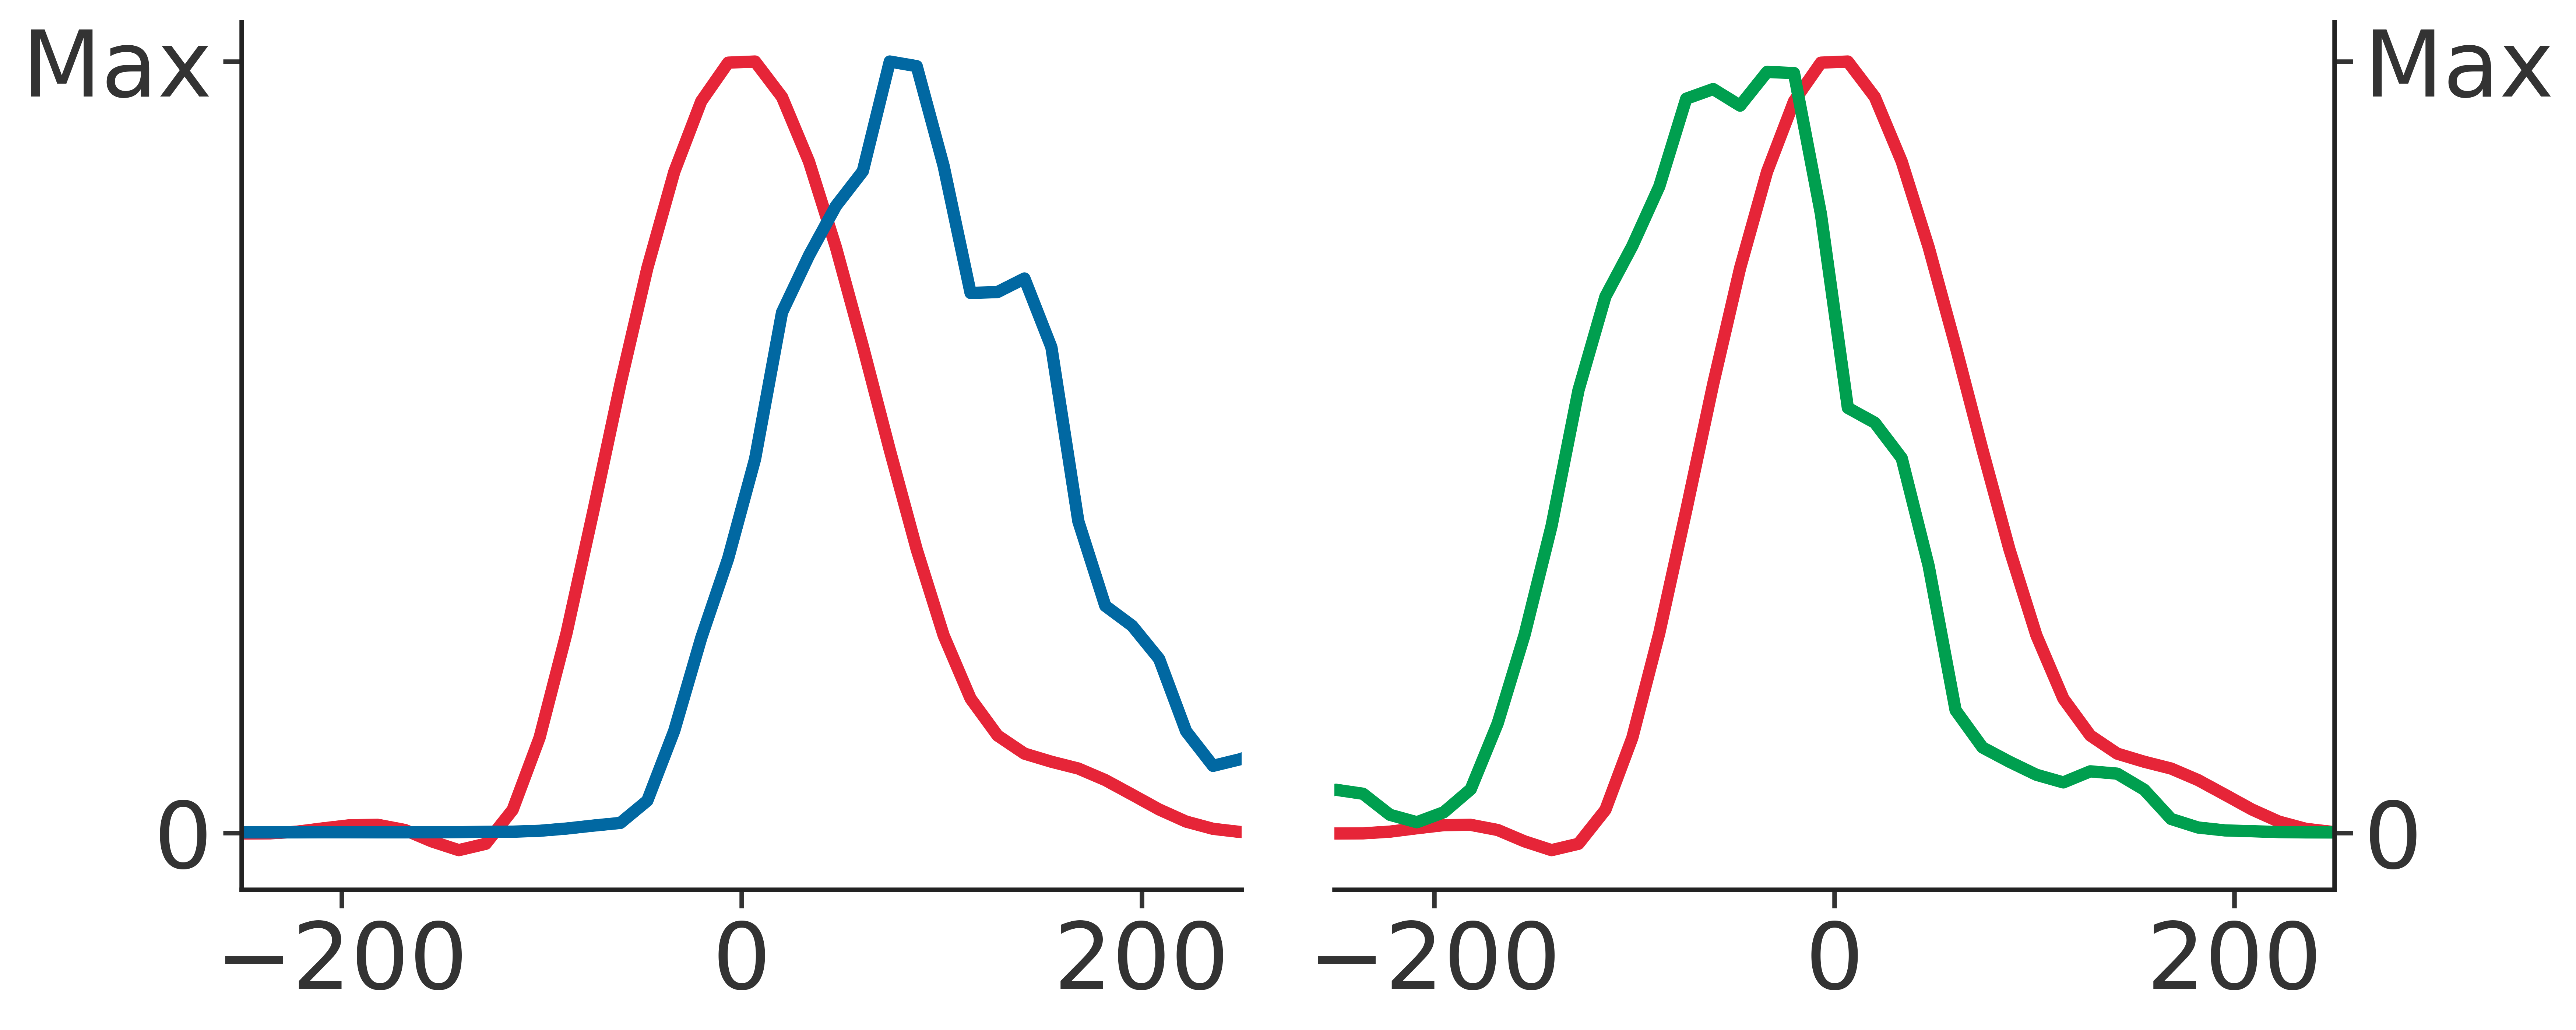

DSet: 15-10-07 Stim whitenoise


<Figure size 3840x2880 with 0 Axes>

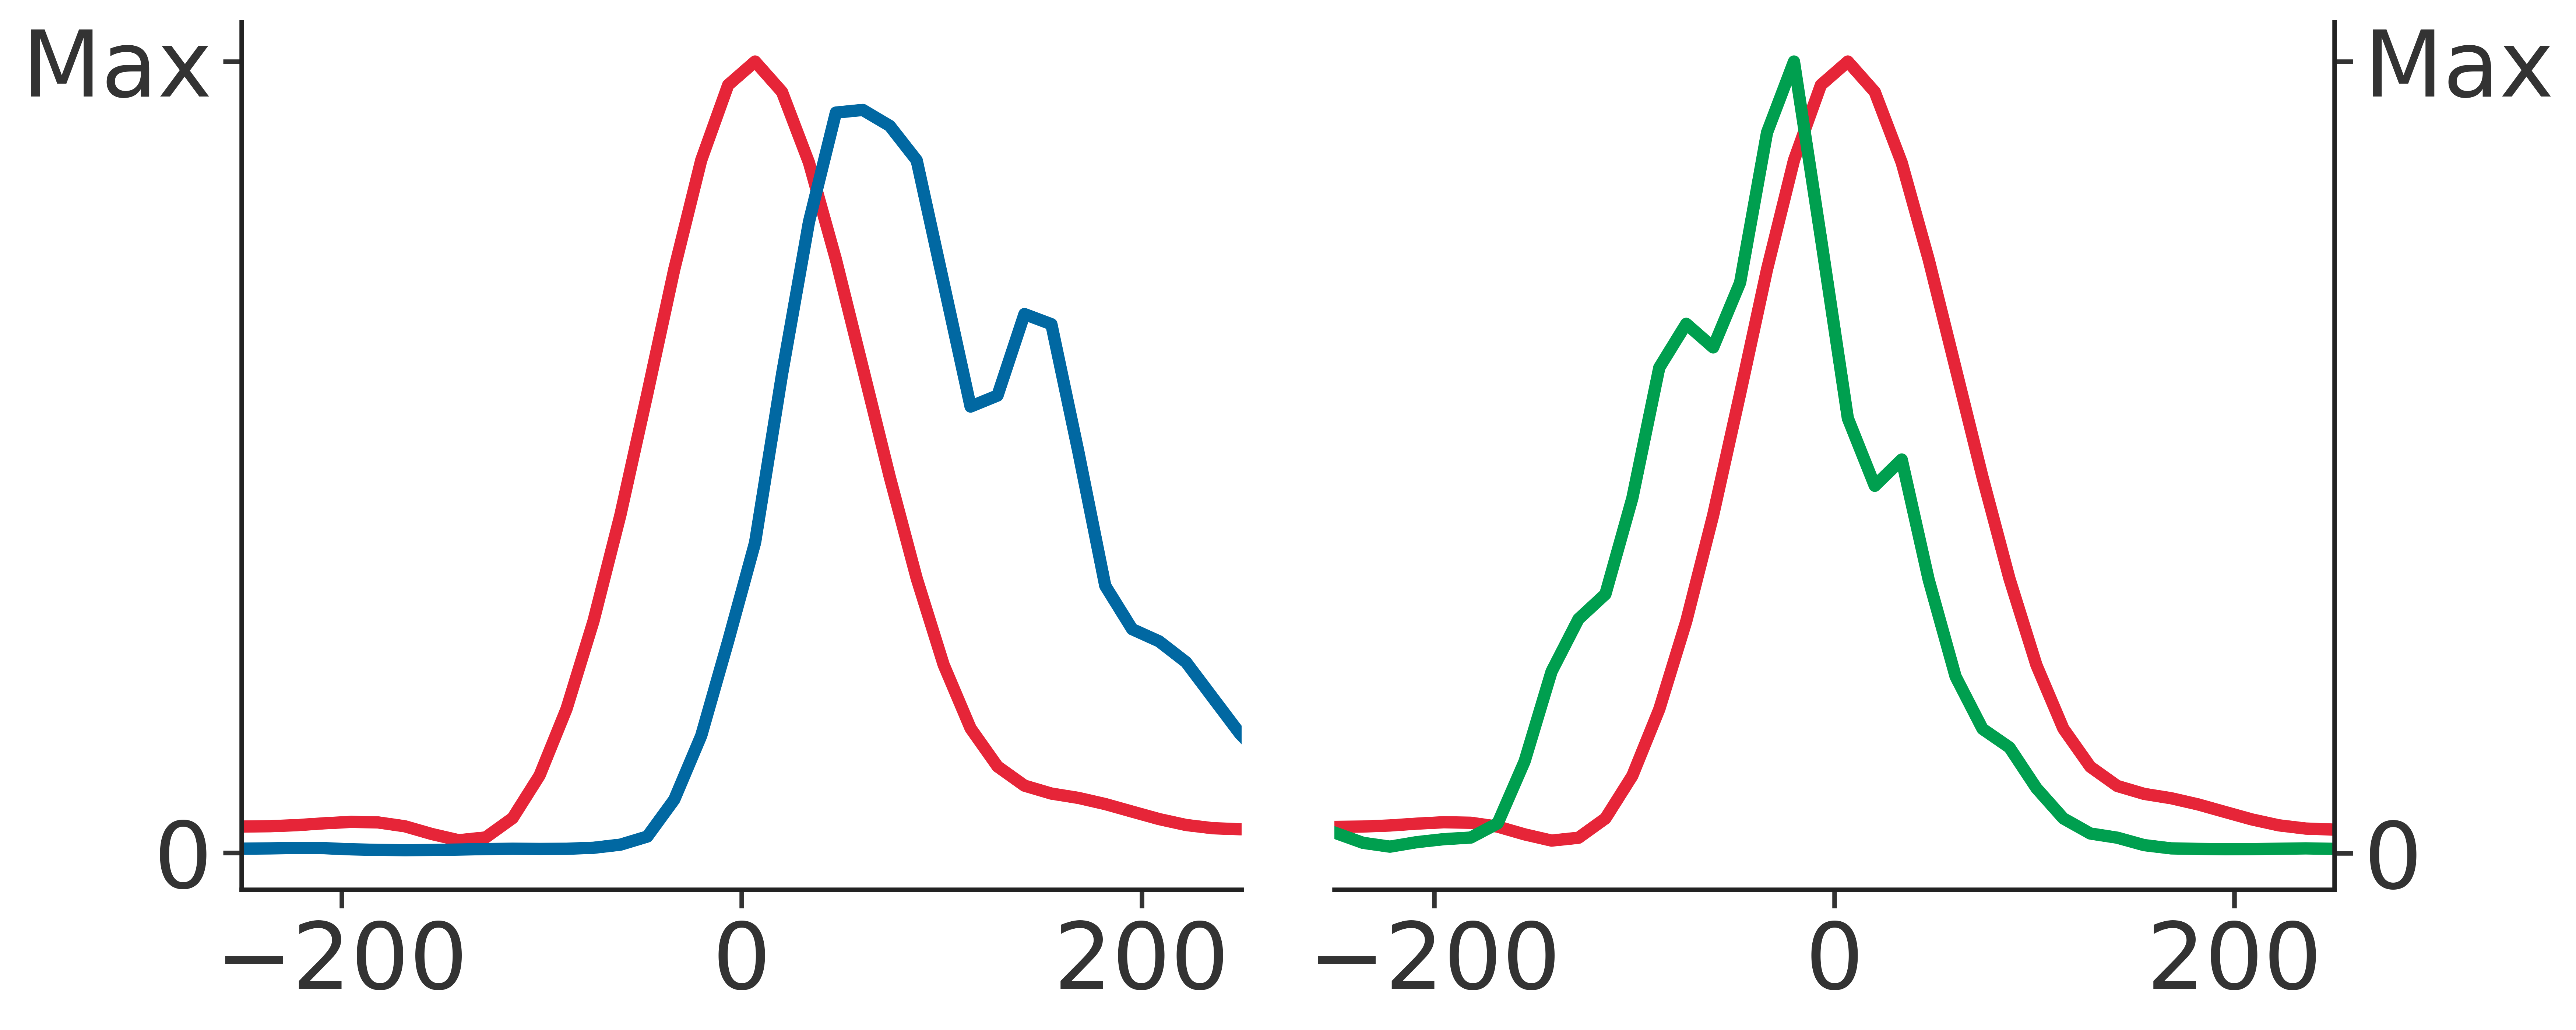

DSet: 15-11-21a Stim naturalscene


<Figure size 3840x2880 with 0 Axes>

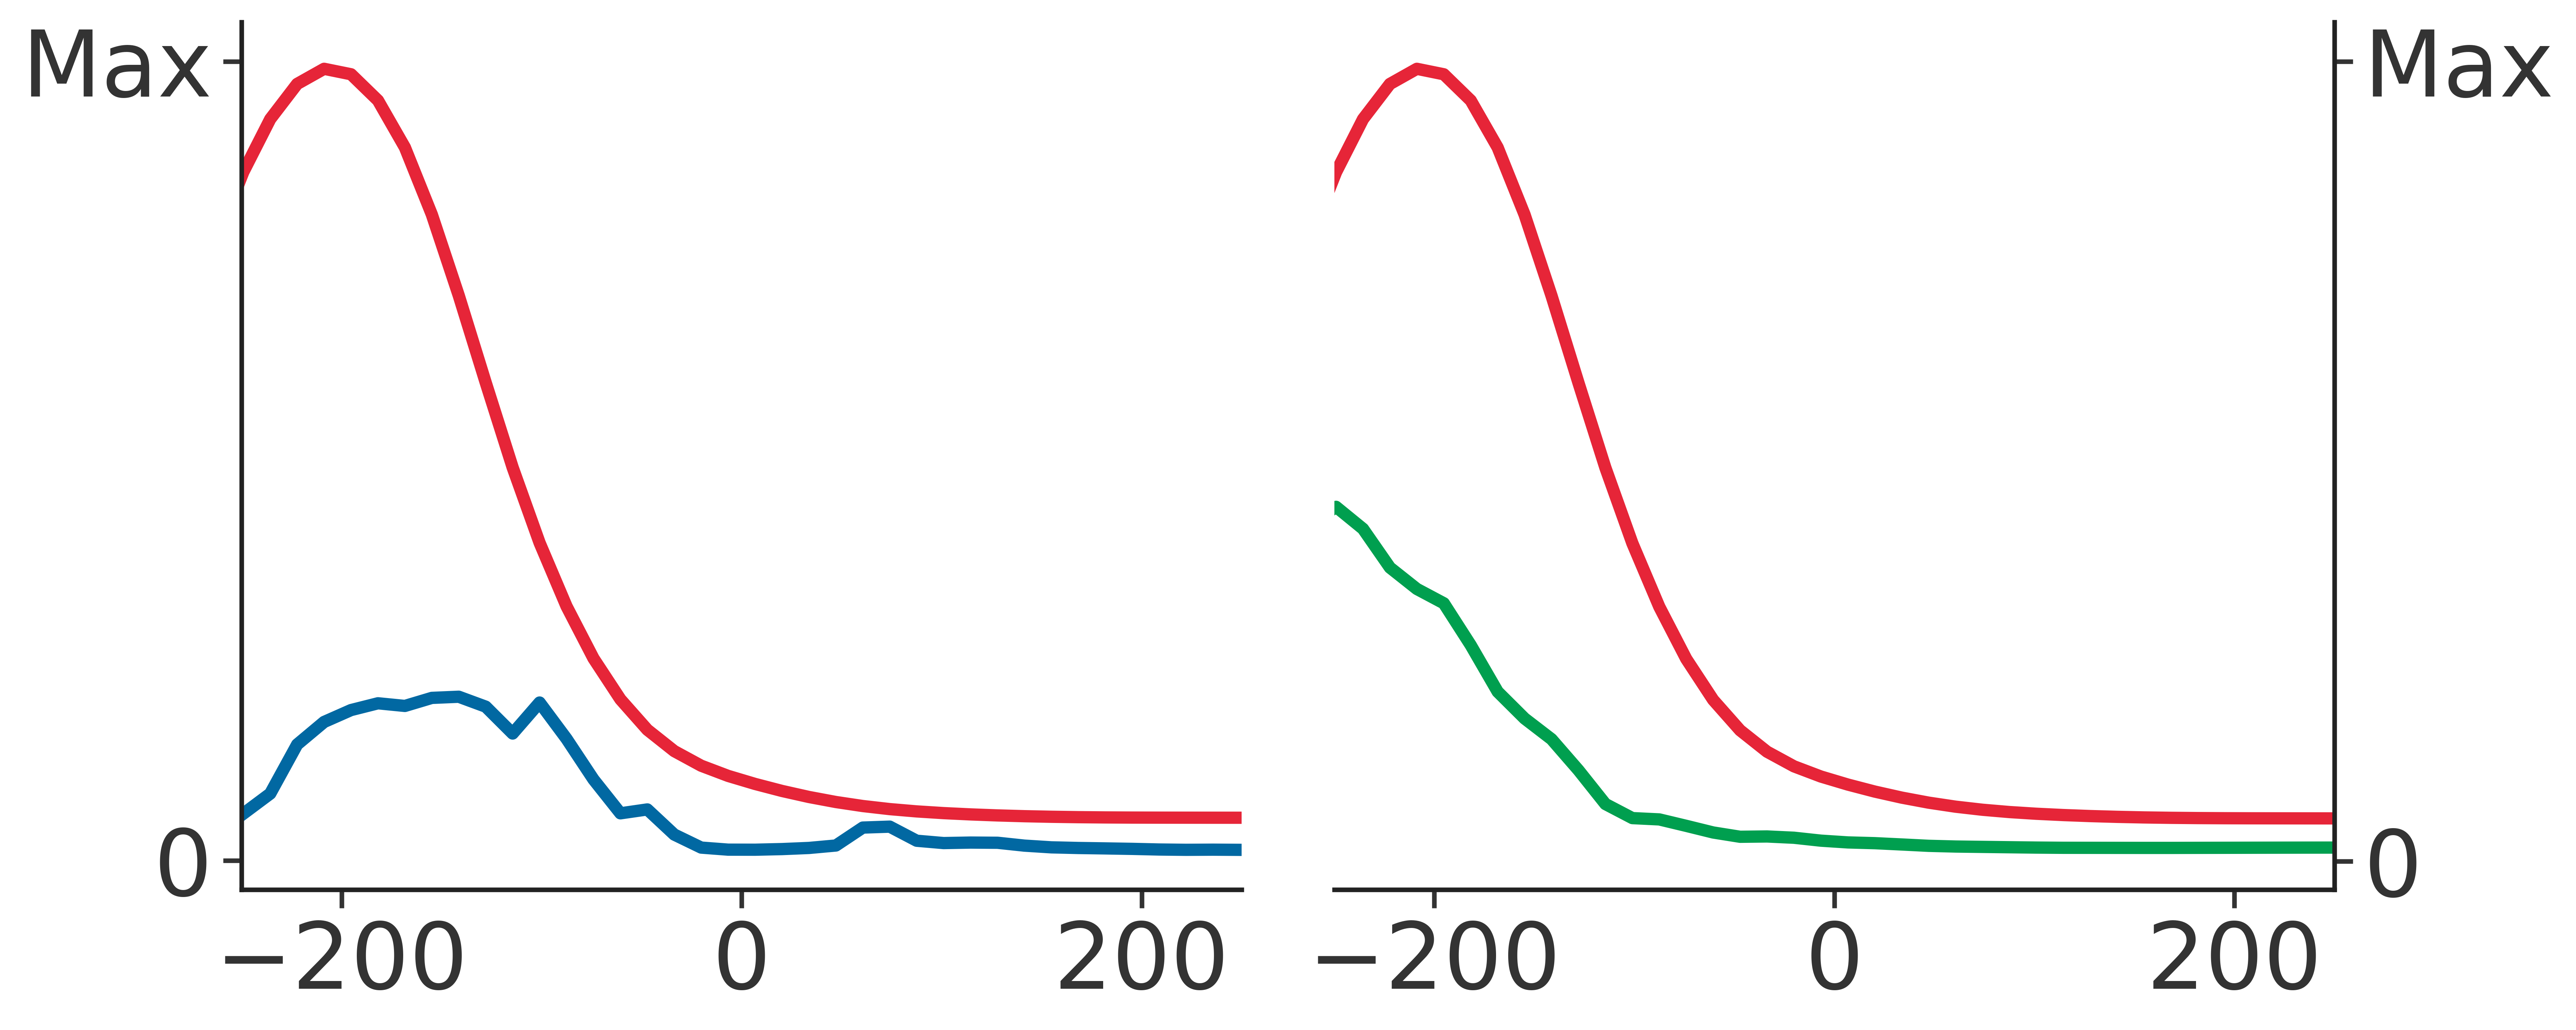

DSet: 15-11-21a Stim whitenoise


<Figure size 3840x2880 with 0 Axes>

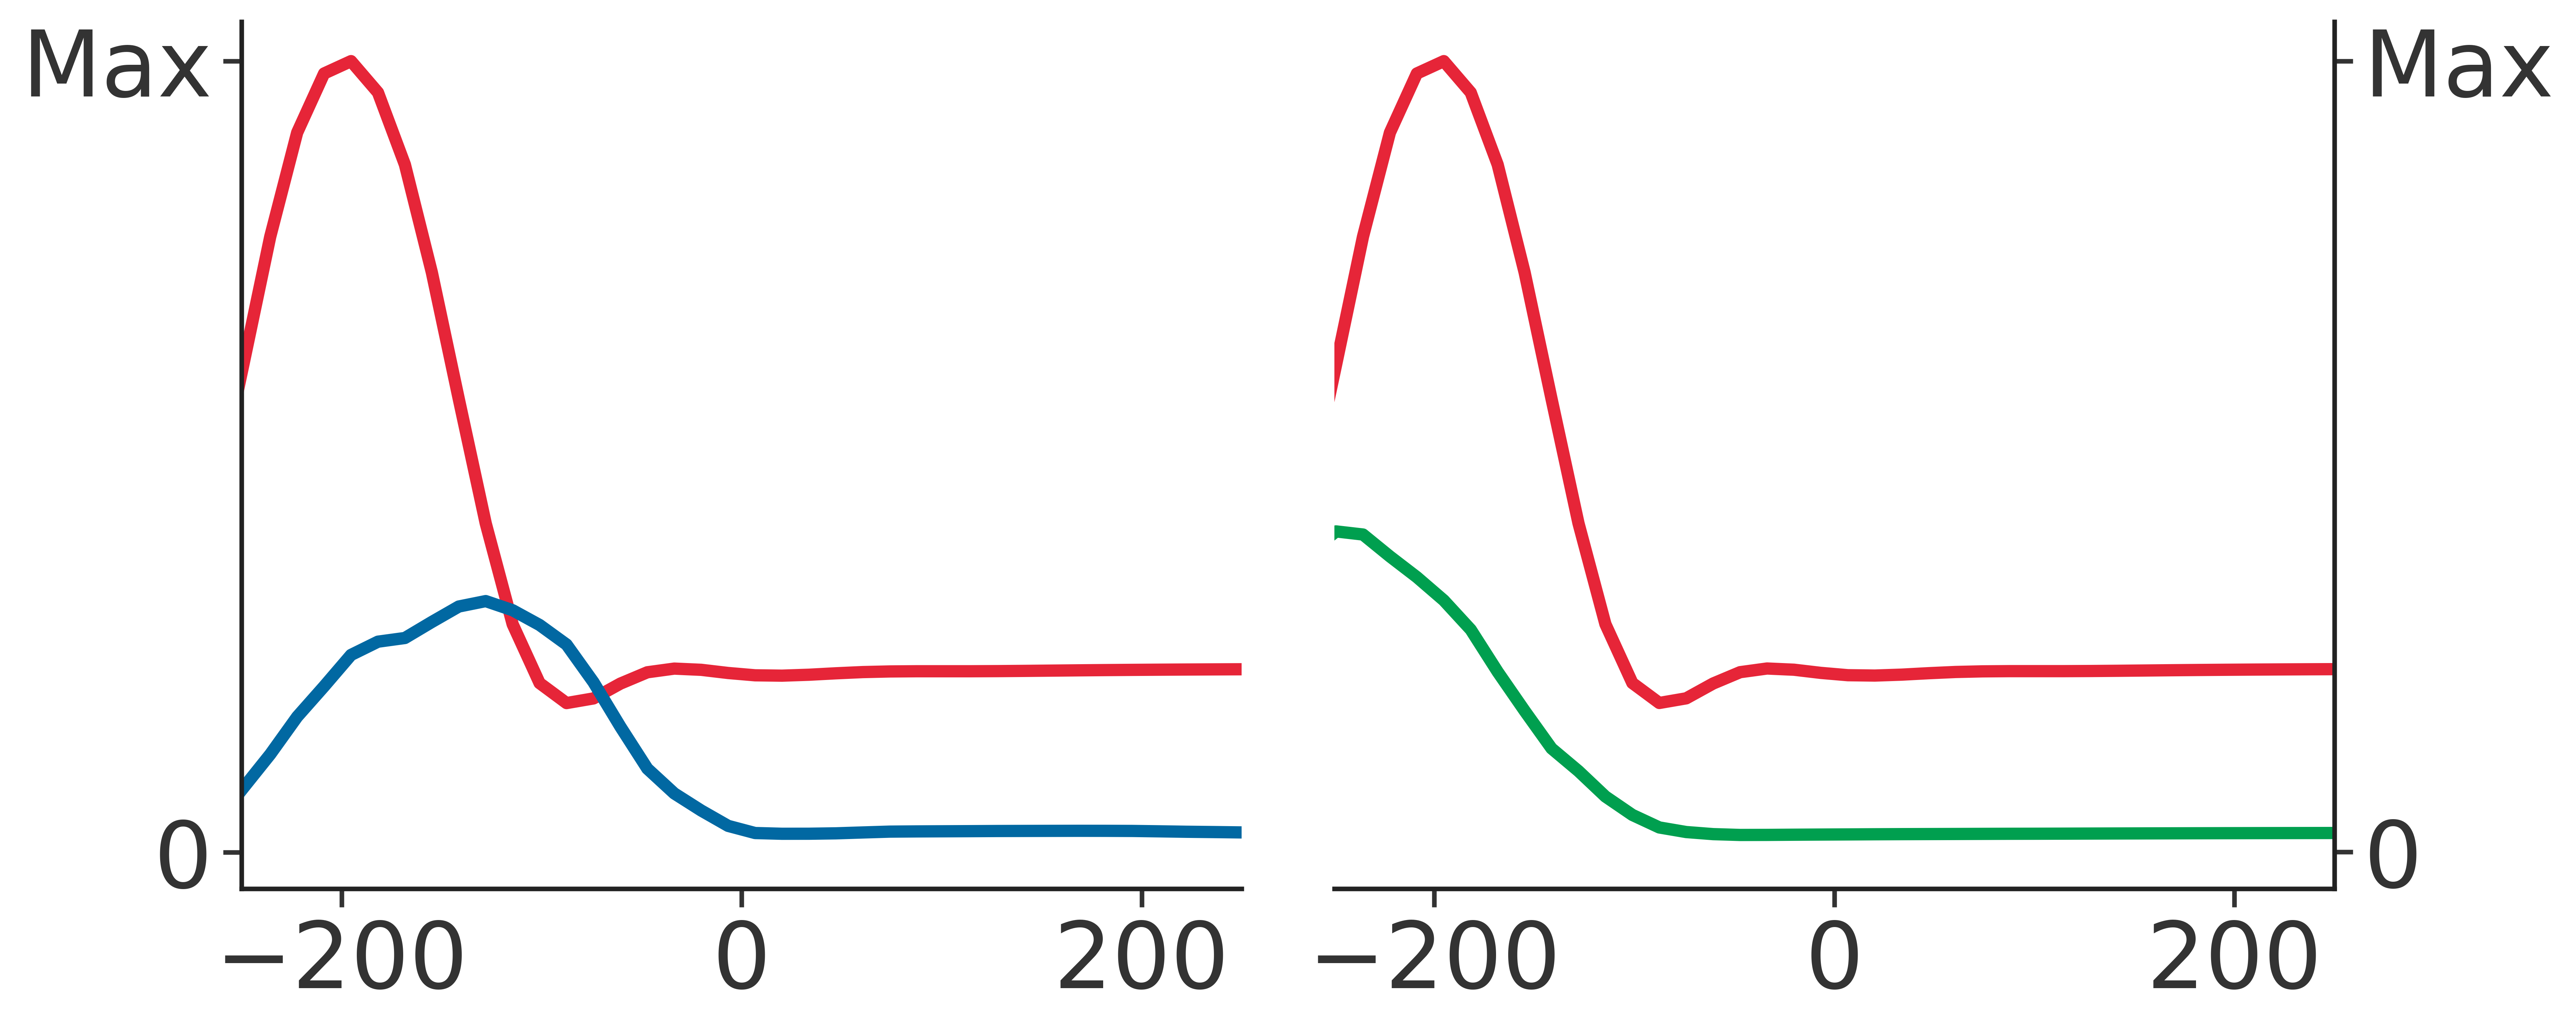

DSet: 15-11-21b Stim naturalscene


<Figure size 3840x2880 with 0 Axes>

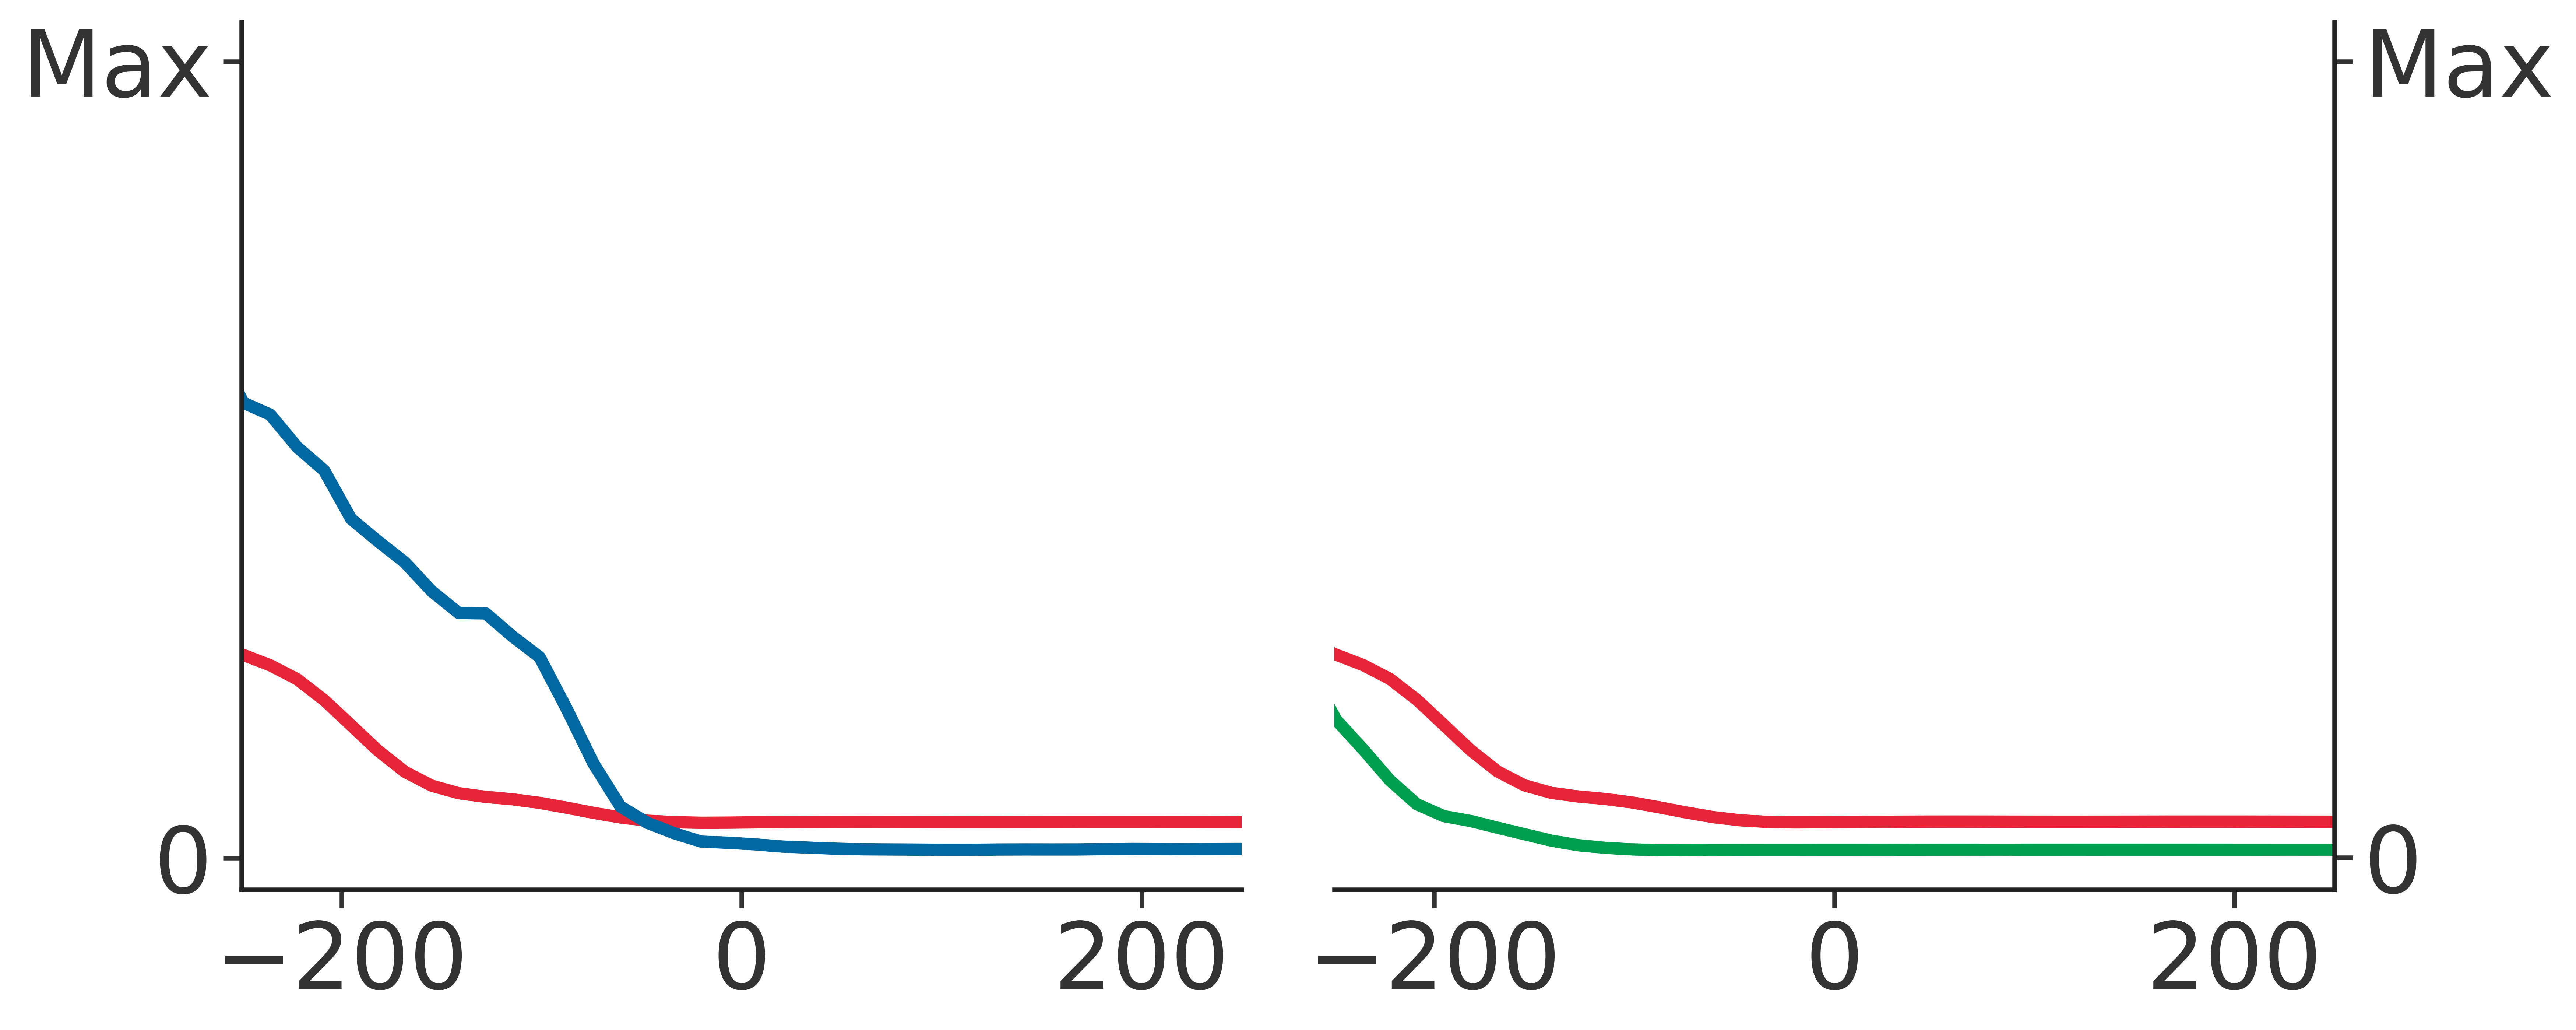

DSet: 15-11-21b Stim whitenoise


<Figure size 3840x2880 with 0 Axes>

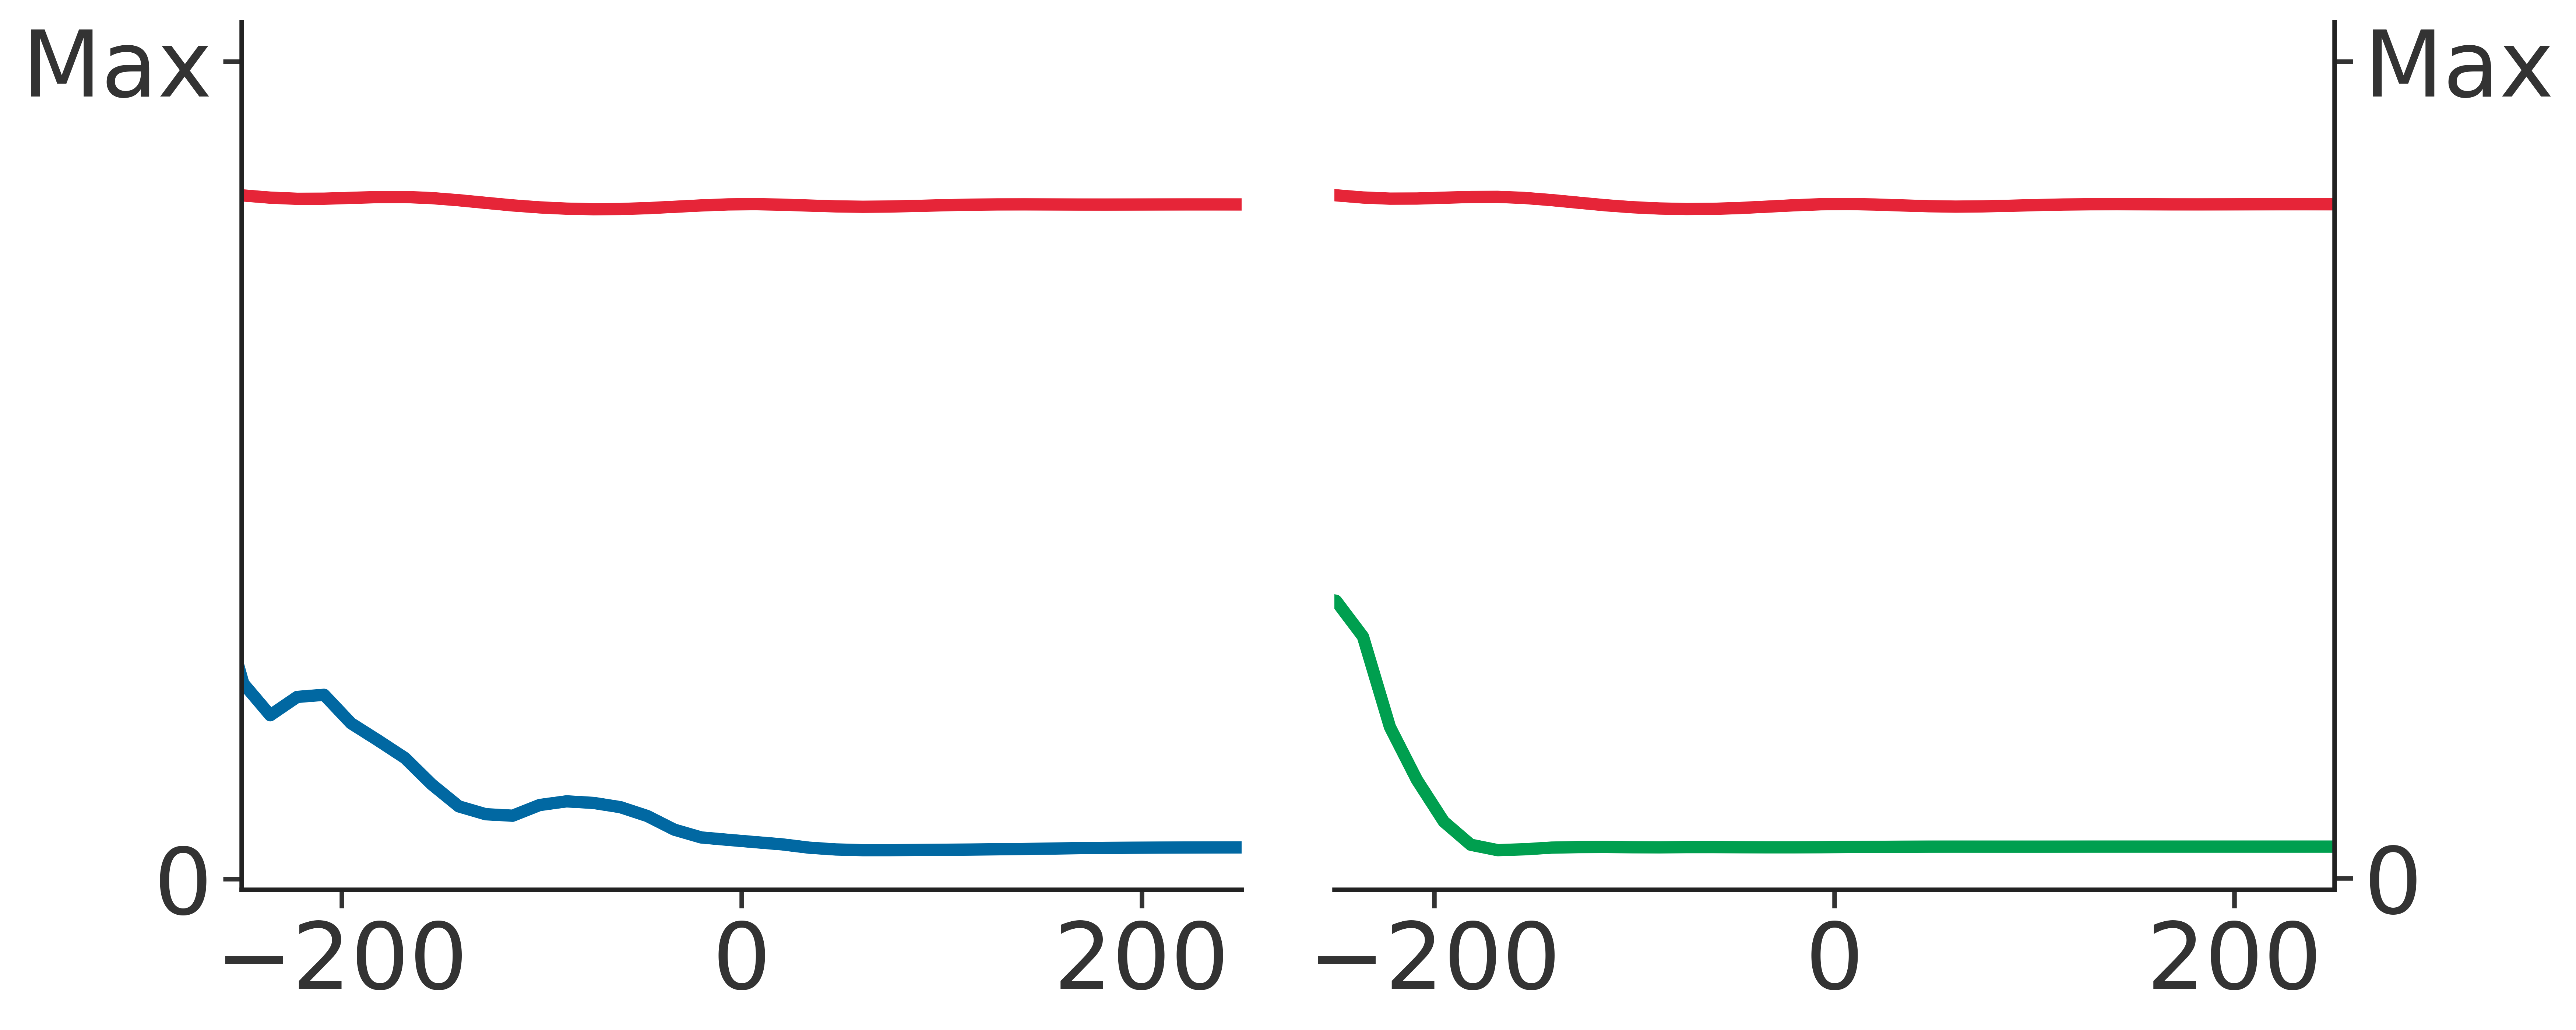

In [21]:
red =   '#E62538'
blue =  '#0168A2'
green = '#009F4F'
for dset in responses.keys():
    for stype in responses[dset].keys():
        print("DSet:", dset, "Stim", stype)
        tup = responses[dset][stype]
        zz, flash, left, right, (f_indy, l_indy, r_indy) = tup
        
        # Plot
        plt.clf()
        fig = plt.figure(figsize=(12, 5))
        red = '#E62538'
        blue = '#0168A2'
        green = '#009F4F'
        
        ax = fig.add_subplot(121)
        ax.plot(zz, flash, color=red, linewidth=4)
        ax.plot(zz, right, color=blue,linewidth=4)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(-250, 250)
        ax.set_xticks([-200, 0, 200])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0', 'Max'])
        ax.tick_params(axis='both', which='major', labelsize=30)
        
        ax = fig.add_subplot(122)
        ax.plot(zz, flash, color=red,linewidth=4)
        ax.plot(zz, left, color=green,linewidth=4)
        ax.set_xlim(-250, 250)
        ax.set_xticks([-200,0, 200])
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0', 'Max'])
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=30)
        
        plt.locator_params(nbins=3)
        plt.tight_layout()
        plt.show()
        
        #plt.savefig(prepath+'motion_anticipation.png')
        #plt.savefig(prepath+'motion_anticipation.pdf')
        
        

In [22]:
diffs = {
    "dset": [],
    "stype": [],
    "ci": [],
    "left": [],
    "right": [],
    "diff": [],
    "center": [],
}
for dset in responses.keys():
    for stype in responses[dset].keys():
        tup = responses[dset][stype]
        zz, flash, left, right, (f_indy, l_indy, r_indy) = tup
        for ci in range(l_indy.shape[0]):
            diffs["dset"].append(dset)
            diffs["stype"].append(stype)
            diffs["ci"].append(ci)
            left = l_indy[ci].argmax()
            right = r_indy[ci].argmax()
            diffs["left"].append(left)
            diffs["right"].append(right)
            diffs["diff"].append(right-left) 
            diffs["center"].append(f_indy[ci].argmax())
df = pd.DataFrame(diffs)
df.head()


,dset,stype,ci,left,right,diff,center
0,15-10-07,naturalscene,0,45,55,10,49
1,15-10-07,naturalscene,1,53,63,10,58
2,15-10-07,naturalscene,2,44,55,11,49
3,15-10-07,naturalscene,3,47,56,9,50
4,15-10-07,naturalscene,4,55,63,8,57


In [23]:
# Cutoff differences that are way below 25
df.loc[df["diff"]<=-25, "diff"] = -25

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


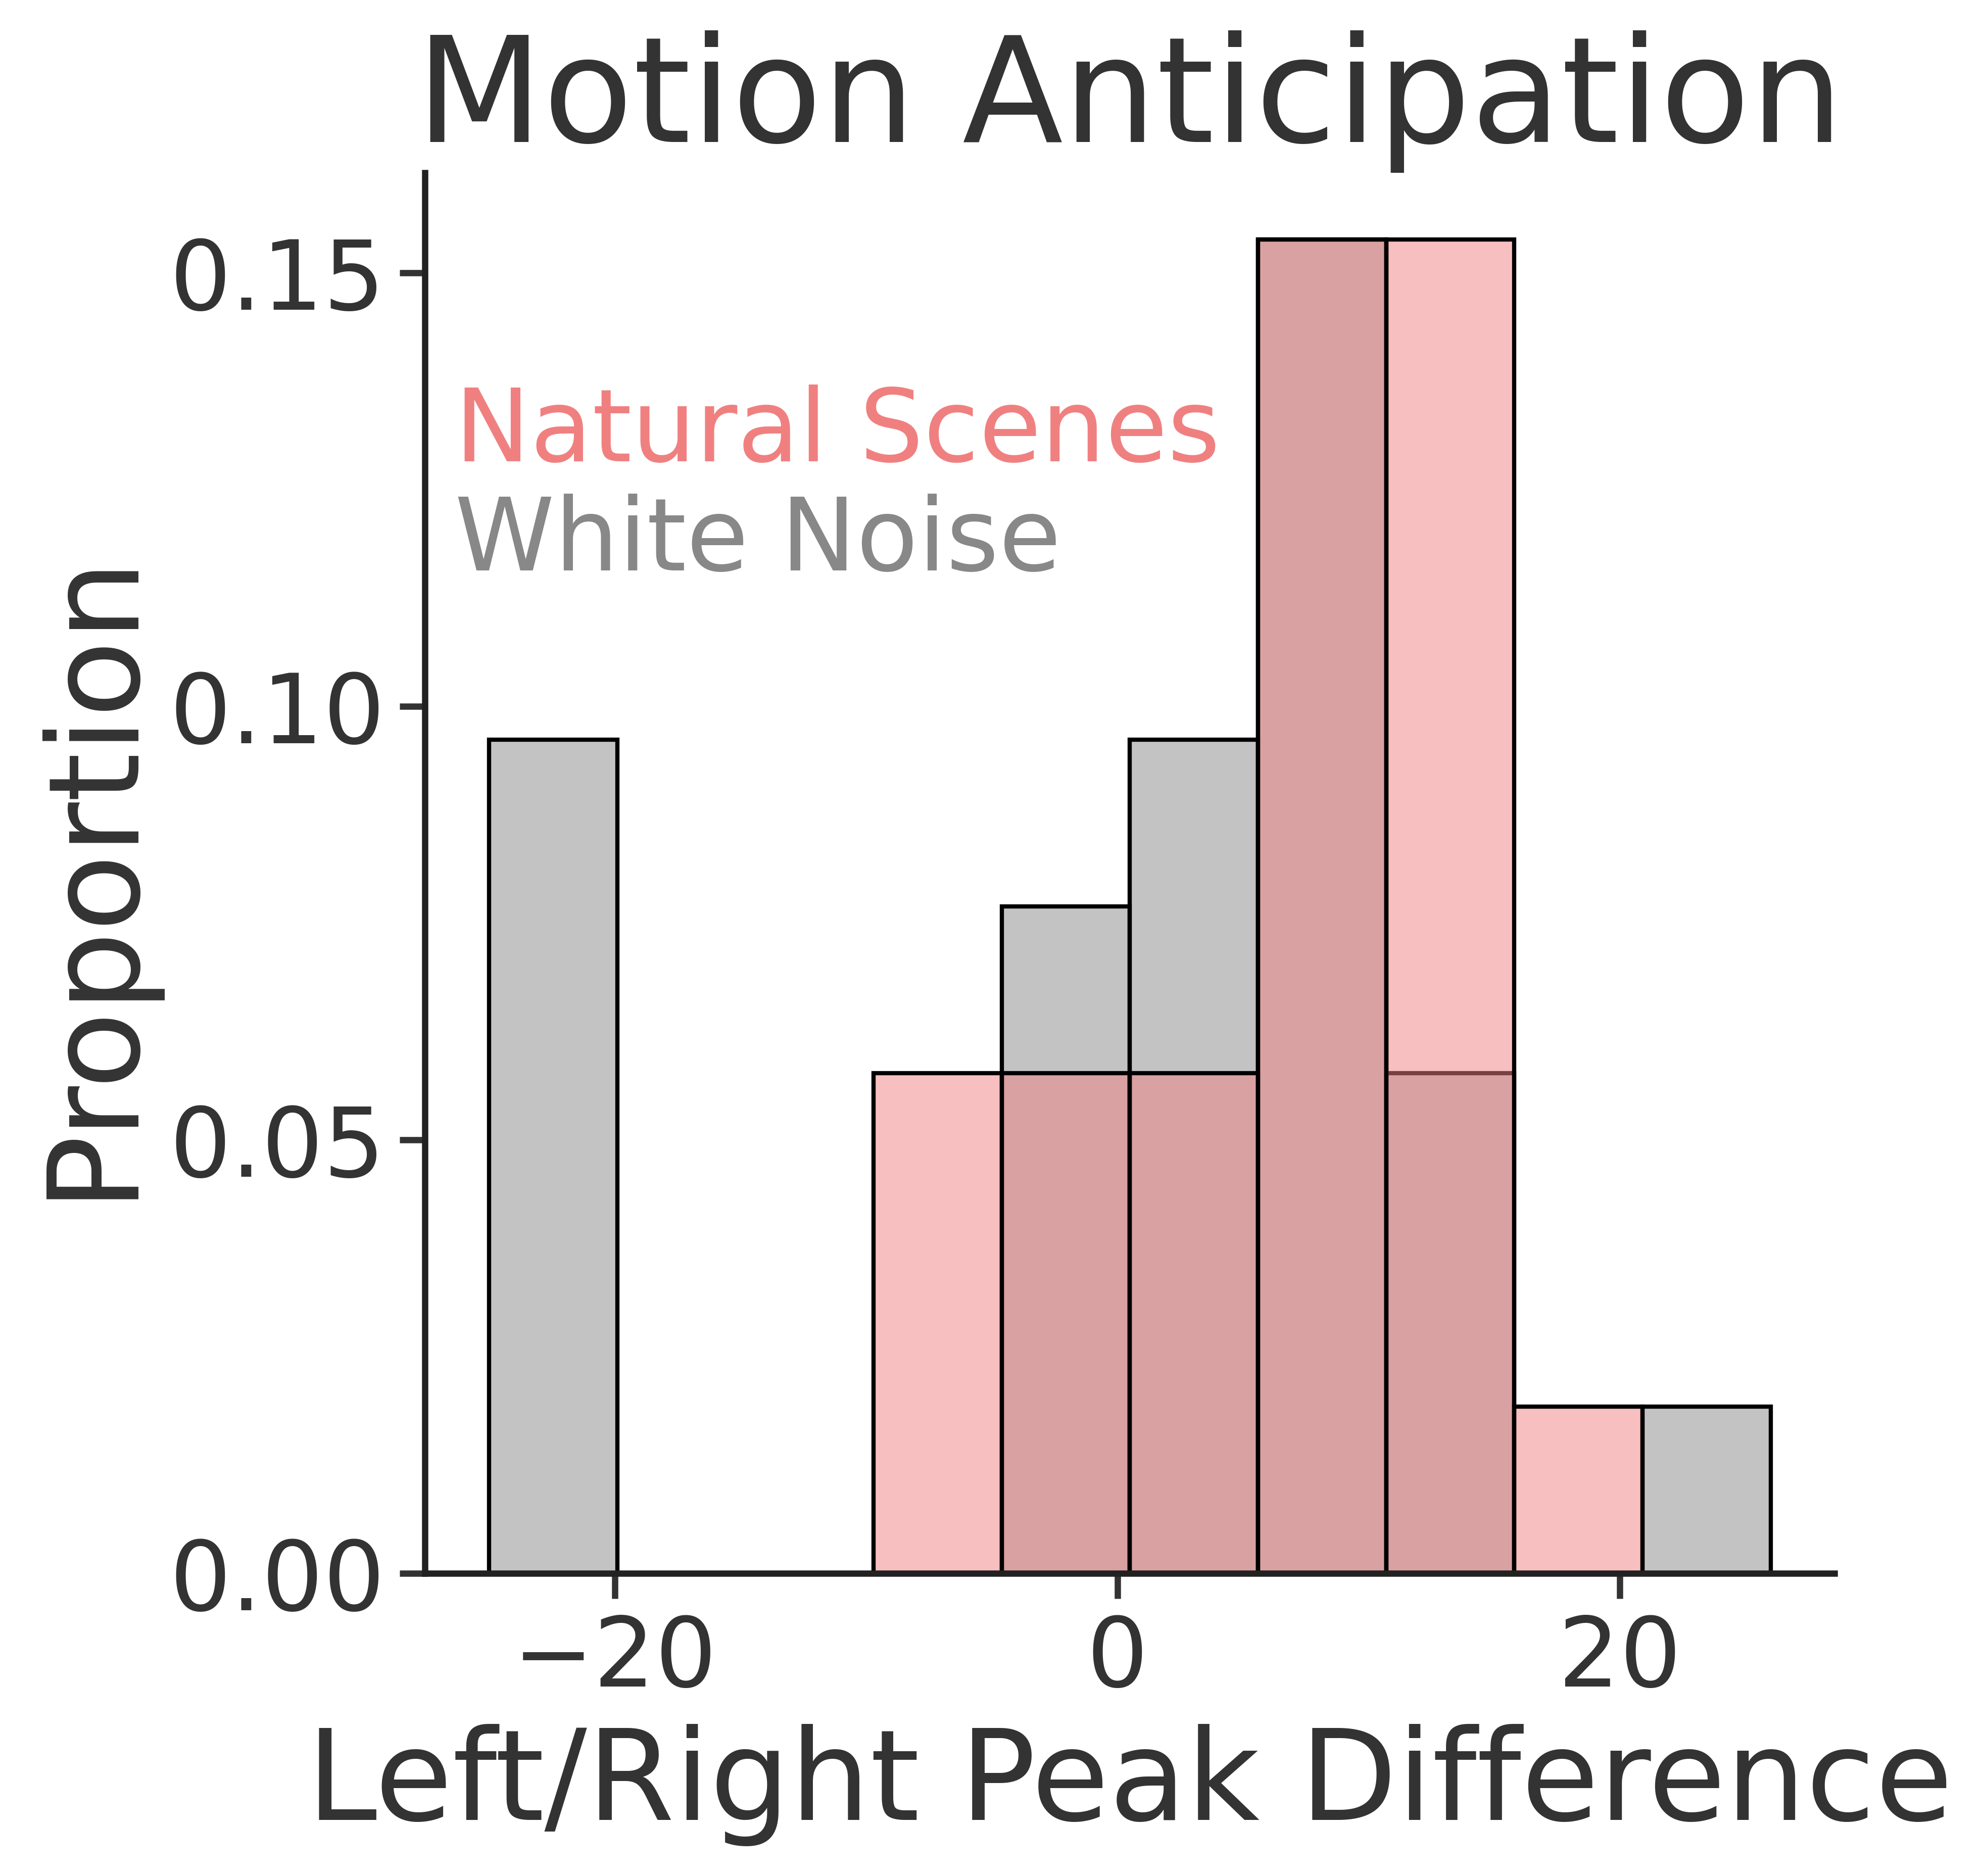

In [28]:
legendsize = 24
fontsize = 30
titlesize = 35
ticksize = 23
alpha = 1
plt.style.use('deepretina.mplstyle')
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.histplot(x="diff", hue="stype", data=df, stat="proportion", ax=ax, palette={"whitenoise": whit_color, "naturalscene": nat_color})

plt.xlabel("Left/Right Peak Difference", fontsize=fontsize)
plt.ylabel("Proportion", fontsize=fontsize)
#plt.yticks([0,0.1,0.2,0.3], fontsize=ticksize)
#plt.xticks([0,0.1,0.2], fontsize=ticksize)
plt.legend().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
plt.title("Motion Anticipation", fontsize=titlesize)

ax.annotate('White Noise', xy=(0.25, 0.76), #xycoords='axes points',
            xycoords="figure fraction",
            size=legendsize, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(0.25, 0.82), #xycoords='axes points',
            xycoords="figure fraction",
            size=legendsize, ha='left', va='top',
            bbox=None,
            color=nat_color)
            

folder_name = "motion_ant"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}motion_ant_hist".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
Histogram of the difference between the peak response of each cell for the leftward and rightward moving bar stimuli.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

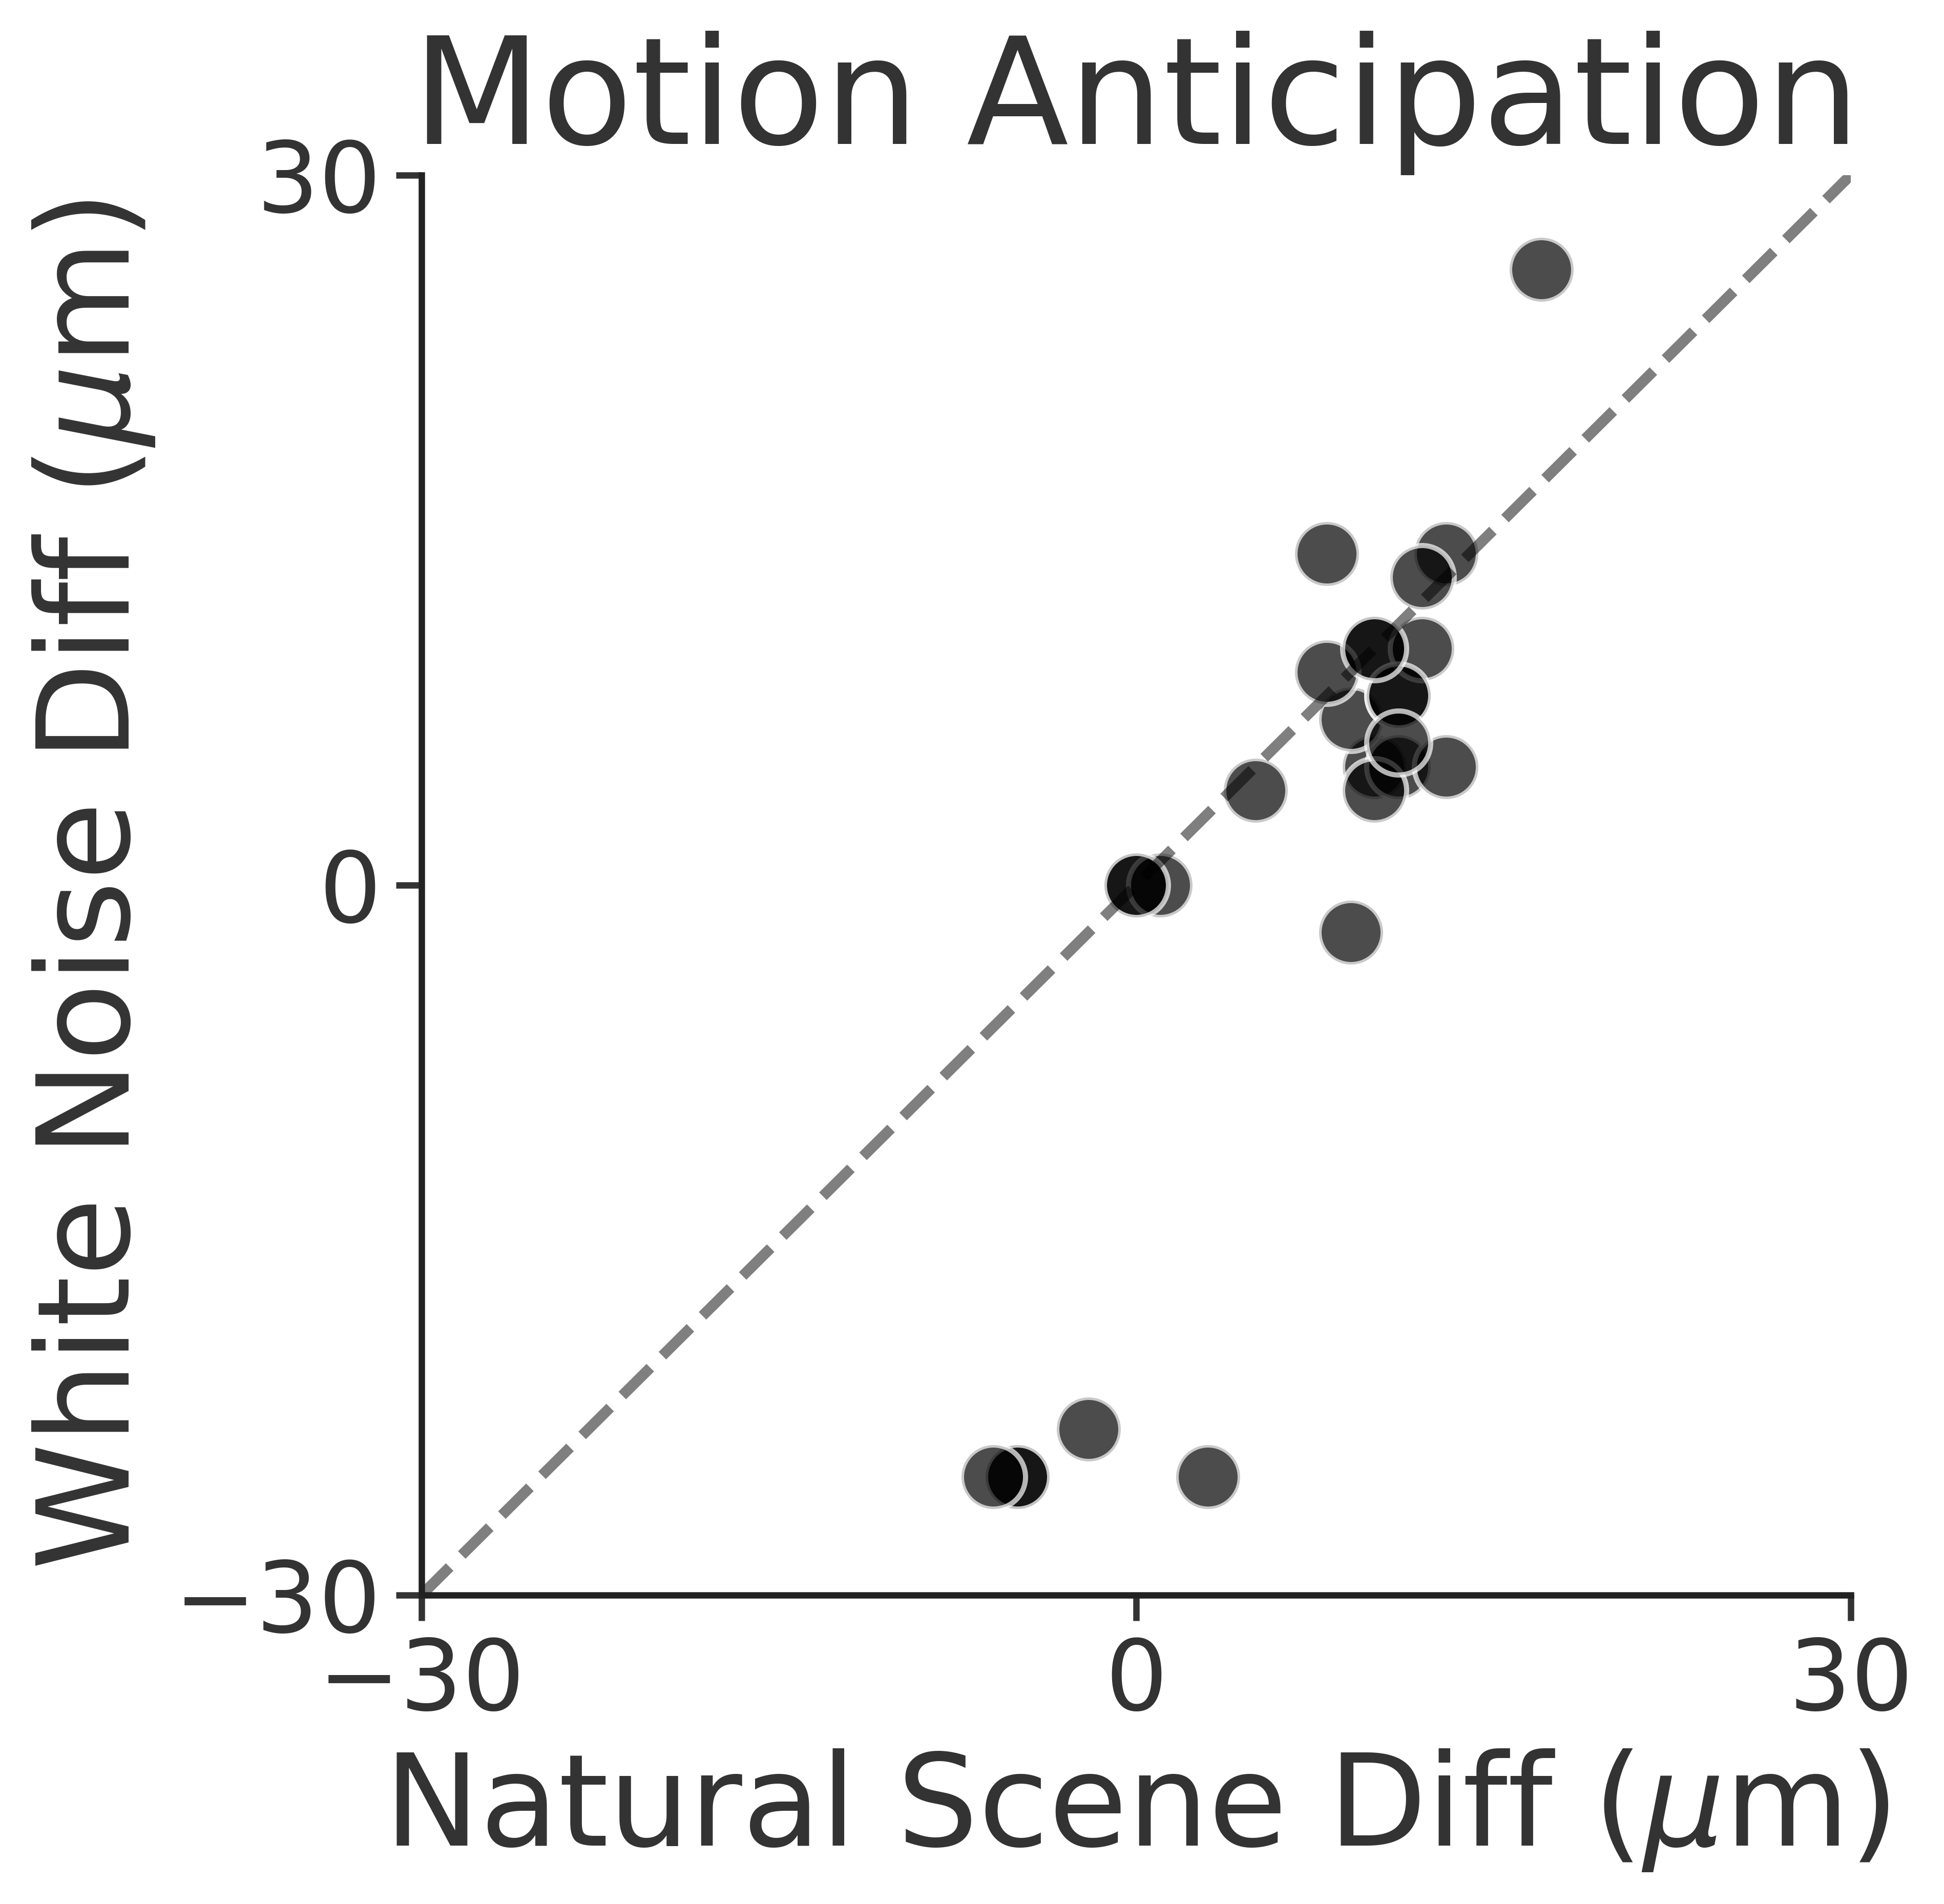

In [29]:
cols = ["stype", "dset", "ci"]
y = np.asarray(df.loc[df["stype"]=="whitenoise"].sort_values(by=cols)["diff"])
x = np.asarray(df.loc[df["stype"]=="naturalscene"].sort_values(by=cols)["diff"])

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x=x,y=y, ax=ax, alpha=0.7, color="black")
ticks = [-30, 0, 30]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
lim = [ticks[0], ticks[-1]]
plt.ylim(lim)
plt.xlim(lim)
ax.plot(np.linspace(lim[0], lim[1], 2), np.linspace(lim[0], lim[1], 2), "--k", alpha=0.5)
plt.ylabel("White Noise Diff ($\mu$m)", fontsize=fontsize)
plt.xlabel("Natural Scene Diff ($\mu$m)", fontsize=fontsize)
plt.title("Motion Anticipation", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "motion_ant"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}motion_ant_scatter".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
White Noise model cell response peak difference between leftward and rightward moving stimuli plotted against Natural Scenes model peak differences for the same cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")